In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

/opt/intel/intelpython3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version 1.7.0


In [29]:
namedict = {0:'sqv', 1:'idv', 2:'nfv', 3:'atv', 4:'tpv', 5:'lpv'}

num_training  = 786

drug_idx = np.zeros(786*6, dtype=int)
mut_idx = np.zeros(786*6, dtype=int)

for i in range(0, 786*6):
    drug_idx[i] = i / 786
    mut_idx[i] = i % 786

np.random.seed(0)    
shuffle_idx = np.random.permutation(np.arange(786*6))
drug_idx = drug_idx[shuffle_idx]
mut_idx = mut_idx[shuffle_idx]

def loaddata3(k):
    kfold_drugs = drug_idx[k*786:k*786+786]
    kfold_muts = mut_idx[k*786:k*786+786]
    
    result_map = np.zeros((786, 41, 35, 32, 7))
    result_label = np.zeros((786,1))
    result_trans = np.zeros((786,14))
    
    
    sorted_drugs = np.sort(kfold_drugs)
    sorted_idx = np.argsort(kfold_drugs)
    sorted_muts = kfold_muts[sorted_idx]
    
        
    trans_data = np.load('trans_elecmap_data.npy')
    trans_data = np.reshape(trans_data, (786,14))
    ground_data = np.load('ground_elecmap_data.npy')
    ground_data = np.reshape(ground_data, (786,14))
    start_idx = 0
    num_curr_muts = 0
    for i in range(0,6):
        while(sorted_drugs[num_curr_muts] == i):              
            num_curr_muts += 1
            if(i == 5):
                num_curr_muts = 786
                break
            
        data = np.load(namedict[i] + '_elecmap_data_avg.npy')[sorted_muts[start_idx:num_curr_muts]][:]
        labels = np.load(namedict[i] + '_labels01.npy')[sorted_muts[start_idx:num_curr_muts]][:]
        #print(labels.shape)
        result_map[start_idx:num_curr_muts][:] = data
        result_label[start_idx:num_curr_muts][:] = labels
        
        temp = trans_data[sorted_muts[start_idx:num_curr_muts]][:] - ground_data[sorted_muts[start_idx:num_curr_muts]][:]
        result_trans[start_idx:num_curr_muts] = temp
        
        start_idx = num_curr_muts
    
    np.random.seed(1)
    shuffle_idx = np.random.permutation(np.arange(786))
    return result_map[shuffle_idx], result_trans[shuffle_idx], result_label[shuffle_idx]
        


In [3]:
def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)


def conv3d(input, kernel_size, stride, num_filter, activation=tf.nn.relu, name="conv"):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, stride, 1]
        print(input.get_shape())
        filter_shape = [kernel_size, kernel_size, kernel_size, input.get_shape()[4], num_filter]

        
        #W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        W = tf.get_variable('w', filter_shape, tf.float32, tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', [1, 1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv3d(input, W, stride_shape, padding='SAME')+ b
        
        #tf.summary.histogram('preactivation', conv)
        final = leaky_relu(conv) 
        #tf.summary.histogram('activation', final)
        #return activation(conv)
        #return leaky_relu(conv)
        return final

def max_pool(input, kernel_size, stride, name=None):
    ksize = [1, kernel_size, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, stride, 1]
    return tf.nn.max_pool3d(input, ksize=ksize, strides=strides, padding='SAME', name=name)

def fc(input, num_output, activation=tf.nn.relu, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return leaky_relu(tf.matmul(input, W) + b)




In [34]:

class BaseModel4(object):
    def __init__(self):
        self.num_epoch = 50
        self.batch_size = 25
        self.log_step = 10
        self._build_model()

    def _seq_fc(self, input, scope, unit1, unit2):
        with tf.variable_scope(scope):
            seq_fc1 = tf.layers.dense(inputs=input, units=unit1)
            norm = tf.contrib.layers.batch_norm(seq_fc1, center=True, scale=True, scope='bn')
            seq_relu1 = leaky_relu(norm)
            seq_fc2 = tf.layers.dense(inputs=seq_relu1, units=unit2)
            seq_relu2 = leaky_relu(seq_fc2)
            seq_dropout = tf.layers.dropout(inputs=seq_relu2, rate=0.2, training=self.dropout_train)            
            return seq_dropout
        
    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('input layer: ' + str(self.X.get_shape()))      
        
        self.conv1 = conv3d(self.X, 10, 1, 32, name='conv1')
        self.norm1 = tf.contrib.layers.batch_norm(self.conv1, center=True, scale=True, scope='bn1')
        self.pool1 = max_pool(self.norm1, 3, 2, name='pool1') 
        print('conv1 layer : ' + str(self.pool1.get_shape()))

        
        self.conv2 = conv3d(self.pool1,8,1,64, name='conv2')
        self.norm2 = tf.contrib.layers.batch_norm(self.conv2, center=True, scale=True, scope='bn2')
        self.pool2 = max_pool(self.norm2, 3, 2, name='pool2')  
        print('conv2 layer : ' + str(self.pool2.get_shape()))
        
        self.conv3 = conv3d(self.pool2,8,1,64, name='conv3')
        self.pool3 = max_pool(self.conv3, 3, 2, name='pool3') 
        print('conv3 layer : ' + str(self.pool3.get_shape()))
        
        proddim = np.prod(self.pool3.get_shape()[1:], dtype=np.uint)
        self.flat = tf.reshape(self.pool3, [-1,proddim ])
        print('flatten layer : ' + str(self.flat.get_shape()))
        
        #self.seq_net = self._seq_fc(self.seq, 'seq_net',99, 14)
        self.trans_net1 = fc(self.trans, num_output=14,name='trans_net1')
        self.trans_norm1 = tf.contrib.layers.batch_norm(self.trans_net1, center=True, scale=True, scope='trans_norm1')
        self.trans_dropout = tf.layers.dropout(inputs=self.trans_norm1, rate=0.1, training=self.dropout_train, name='trans_dropout') 
        self.trans_net2 = fc(self.trans_dropout, num_output=14, name='trans_net2')
        self.trans_norm2 = tf.contrib.layers.batch_norm(self.trans_net2, center=True, scale=True, scope='trans_norm2')
        
        
        self.fc4 = fc(self.flat, num_output=1024, name='fc4')
        self.norm4 = tf.contrib.layers.batch_norm(self.fc4, center=True, scale=True, scope='bn4')

        self.dropout4 = tf.layers.dropout(inputs=self.norm4, rate=0.2, training=self.dropout_train, name='dropout4')
        print('fc4 layer : ' + str(self.dropout4.get_shape()))

        self.fc5 = fc(self.dropout4, num_output=384, name='fc5')
        self.norm5 = tf.contrib.layers.batch_norm(self.fc5, center=True, scale=True, scope='bn5')
       
        self.dropout5 = tf.layers.dropout(inputs=self.norm5, rate=0.2, training=self.dropout_train, name='dropout5') 
        print('fc5 layer : ' + str(self.fc5.get_shape()))
        
        self.fc6 = fc(self.dropout5, num_output=14, name='fc6')
        self.norm6 = tf.contrib.layers.batch_norm(self.fc6, center=True, scale=True, scope='bn6')
        print('fc6 layer : ' + str(self.fc6.get_shape()))

        
        self.concat = tf.concat([self.norm6, self.trans_norm2],1)
        print('concatenated tensors: ' + str(self.concat.get_shape()))
        self.concat_fc = fc(self.concat, num_output=28, name='concat_fc')   
        self.concat_norm1 = tf.contrib.layers.batch_norm(self.concat_fc, center=True, scale=True, scope='concat_norm1')
        self.concat_fc2 = fc(self.concat_norm1, num_output=28, name='concat_fc2')
        self.concat_norm2 = tf.contrib.layers.batch_norm(self.concat_fc2, center=True, scale=True, scope='concat_norm2')
        self.concat_drop = tf.layers.dropout(inputs=self.concat_norm2, rate=0.2, training=self.dropout_train, name='concat_dropout')
        print('concat fc-fc layer : ' + str(self.concat_drop.get_shape()))
        
        #self.fc6 = fc(self.concat_fc, num_output=3, name='fc6')
        self.fc_final = fc(self.concat_drop, num_output=2, name='fc_final')
        print('fc final layer : ' + str(self.fc_final.get_shape()))
      

       
        return self.fc_final

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 41, 35, 32,7])
        self.trans = tf.placeholder(tf.float32, [None, 14])
        self.Y = tf.placeholder(tf.int64, [None])
        self.dropout_train = tf.placeholder(tf.bool)
        
        
        self.is_train = None
        self.keep_prob = None      

    def _build_optimizer(self):
        global_step = tf.Variable(0, trainable=False)
        lr = tf.train.exponential_decay(learning_rate=5e-4, decay_steps=500, decay_rate=0.99, global_step=global_step)
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)        
        self.train_op = optimizer.minimize(loss=self.loss_op,global_step=global_step)      
        
    def _loss(self, labels, logits):  
        #self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels)        
        weights = tf.constant([0.1, 1.0])
        self.cross_entropy = tf.nn.weighted_cross_entropy_with_logits(logits=logits,targets=labels, pos_weight=weights)        
        mean = tf.reduce_mean(self.cross_entropy)
        tf.add_to_collection('losses', mean)
        self.loss_op = tf.add_n(tf.get_collection('losses'))
        
        self.pool3grad = tf.gradients(labels, self.pool3)

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 2)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        self.predict = tf.argmax(logits, 1)        
        correct = tf.equal(self.predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, k):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        prediction_list = np.array([])
        ground_list = np.array([])
        num_iter = num_training // self.batch_size
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            #target_idx = np.arange(5)
            #np.random.shuffle(target_idx)
            prediction_list = np.array([])
            ground_list = np.array([])
            for j in range(0, 6):
                if(j==k):
                    continue


                X_train, trans_train, Y_train = loaddata3(j)
                #X_train = np.reshape(X_train, (len(Y_train), 41,35,32,1))     
                Y_train = np.reshape(Y_train, (len(Y_train), ))
                ground_list = np.append(ground_list, Y_train)
                
                

                for i in range(num_iter + 1):
                    if(i == num_iter):                                                
                        X_ = X_train[i * self.batch_size:][:]
                        trans_ = trans_train[i * self.batch_size:][:]
                        Y_ = Y_train[i * self.batch_size:]
                    else:                        
                        X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                        trans_ = trans_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                        Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                    feed_dict = { 
                        self.X : X_,
                        self.Y : Y_,     
                        self.trans : trans_,
                        self.dropout_train : True,
                    }                


                    #fetches = [self.train_op, self.loss_op, self.accuracy_op]                
                    fetches = [self.train_op, self.loss_op, self.accuracy_op, self.predict]                
                    _, loss, accuracy, prediction = sess.run(fetches, feed_dict=feed_dict)
                    losses.append(loss)
                    accuracies.append(accuracy)
                    prediction_list = np.append(prediction_list, prediction)
                    
                    #print(prediction_list.shape)                    

                    #print(np.mean(X_))
                    #print("ground  Y : ", np.transpose(Y_.astype(int)))
                    #print("predicted : ", np.sum(prediction), "  ground : ", np.sum(Y_))
                    #print(type(prediction))
                    #print("predicted : ", np.sum(prediction)/25, "  ground : ", np.sum(Y_)/25)
                    #if step % self.log_step == 0:
                    #    print('iteration (%d): loss = %.3f, accuracy = %.3f, f1_score = %.3f' %
                    #        (step, loss, accuracy, f1))
                    step += 1
            
     
            print('training for epoch %d' % epoch)
            f1 = f1_score(ground_list, prediction_list, average='weighted')
            curr_accuracy = np.sum((ground_list==prediction_list))/len(ground_list)
            print('-  epoch %d: training f1 = %.3f || training accuracy = %.3f' % (epoch, f1, curr_accuracy))
            #with tf.variable_scope("fc6", reuse=True):
            #    weight = tf.get_variable("w")
            #print(sess.run(weight))
            
            print('validation for epoch %d' % epoch)
            val_f1, val_accuracy = self.evaluate(sess, k)
            print('-  epoch %d: validation f1 = %.3f || validation accuracy = %.3f' % (epoch, val_f1, val_accuracy))
            
        x = np.linspace(0, len(losses),len(losses))
        plt.subplot(1,2,1)
        plt.plot(x, losses, 'r')
        plt.xlabel('iteration')
        plt.ylabel('training loss')
        plt.title('Epoch' + str(epoch) + 'vs Training loss')
        plt.subplot(1,2,2)
        plt.plot(x, accuracies, 'b')
        plt.xlabel('iteration')
        plt.ylabel('training accuracy')
        plt.title('Epoch' + str(epoch) + ' vs Training accuracy')
            
        plt.show()
        
    def evaluate(self, sess,k):
        eval_accuracy = 0.0
        eval_iter = 0
        f1 = 0
        prediction_list = np.array([])
        ground_list = np.array([])
        num_iter = num_training // self.batch_size
        
              
        X_eval, trans_eval, Y_eval = loaddata3(k)
        #X_eval = np.reshape(X_eval, (len(Y_eval), 41,35,32,1))     
        Y_eval = np.reshape(Y_eval, (len(Y_eval), ))

        for i in range(num_iter+1):
            if(i == num_iter):
                X_ = X_eval[i * self.batch_size:][:]
                trans_ = trans_eval[i * self.batch_size:][:]
                Y_ = Y_eval[i * self.batch_size:]                     
            else:
                X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
                trans_ = trans_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]                   

            feed_dict = { 
                    self.X : X_,
                    self.Y : Y_, 
                    self.trans : trans_,

                    self.dropout_train : False,
                }  
                    #fetches = [self.train_op, self.loss_op, self.accuracy_op]                
            fetches = [self.accuracy_op, self.predict]                
            _, loss, accuracy, prediction = sess.run(fetches, feed_dict=feed_dict)  
            prediction_list = np.append(prediction_list, prediction)
            
            
            
      
            #accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        f1 = f1_score(Y_eval, prediction_list, average='weighted')
        #return eval_accuracy / eval_iter    
        return f1 , eval_accuracy / eval_iter    


-----  Sample model  -----
input layer: (?, 41, 35, 32, 7)
(?, 41, 35, 32, 7)
conv1 layer : (?, 21, 18, 16, 32)
(?, 21, 18, 16, 32)
conv2 layer : (?, 11, 9, 8, 64)
(?, 11, 9, 8, 64)
conv3 layer : (?, 6, 5, 4, 64)
flatten layer : (?, 7680)
fc4 layer : (?, 1024)
fc5 layer : (?, 384)
fc6 layer : (?, 14)
concatenated tensors: (?, 28)
concat fc-fc layer : (?, 28)
fc final layer : (?, 2)
-----  Start training  -----
training for epoch 0
-  epoch 0: training f1 = 0.552 || training accuracy = 0.527
validation for epoch 0
-  epoch 0: validation f1 = 0.571 || validation accuracy = 0.543
training for epoch 1
-  epoch 1: training f1 = 0.570 || training accuracy = 0.546
validation for epoch 1
-  epoch 1: validation f1 = 0.577 || validation accuracy = 0.551
training for epoch 2
-  epoch 2: training f1 = 0.557 || training accuracy = 0.532
validation for epoch 2
-  epoch 2: validation f1 = 0.574 || validation accuracy = 0.547
training for epoch 3
-  epoch 3: training f1 = 0.566 || training accuracy = 

training for epoch 45
-  epoch 45: training f1 = 0.668 || training accuracy = 0.649
validation for epoch 45
-  epoch 45: validation f1 = 0.659 || validation accuracy = 0.639
training for epoch 46
-  epoch 46: training f1 = 0.673 || training accuracy = 0.654
validation for epoch 46
-  epoch 46: validation f1 = 0.651 || validation accuracy = 0.631
training for epoch 47
-  epoch 47: training f1 = 0.686 || training accuracy = 0.669
validation for epoch 47
-  epoch 47: validation f1 = 0.681 || validation accuracy = 0.664
training for epoch 48
-  epoch 48: training f1 = 0.698 || training accuracy = 0.681
validation for epoch 48
-  epoch 48: validation f1 = 0.679 || validation accuracy = 0.659
training for epoch 49
-  epoch 49: training f1 = 0.709 || training accuracy = 0.692
validation for epoch 49
-  epoch 49: validation f1 = 0.694 || validation accuracy = 0.675


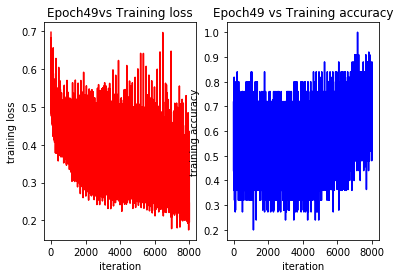

Model saved in ./project0.ckpt
-----  Sample model  -----
input layer: (?, 41, 35, 32, 7)
(?, 41, 35, 32, 7)
conv1 layer : (?, 21, 18, 16, 32)
(?, 21, 18, 16, 32)
conv2 layer : (?, 11, 9, 8, 64)
(?, 11, 9, 8, 64)
conv3 layer : (?, 6, 5, 4, 64)
flatten layer : (?, 7680)
fc4 layer : (?, 1024)
fc5 layer : (?, 384)
fc6 layer : (?, 14)
concatenated tensors: (?, 28)
concat fc-fc layer : (?, 28)
fc final layer : (?, 2)
-----  Start training  -----
training for epoch 0
-  epoch 0: training f1 = 0.565 || training accuracy = 0.540
validation for epoch 0
-  epoch 0: validation f1 = 0.560 || validation accuracy = 0.533
training for epoch 1
-  epoch 1: training f1 = 0.574 || training accuracy = 0.550
validation for epoch 1
-  epoch 1: validation f1 = 0.599 || validation accuracy = 0.575
training for epoch 2
-  epoch 2: training f1 = 0.577 || training accuracy = 0.553
validation for epoch 2
-  epoch 2: validation f1 = 0.596 || validation accuracy = 0.572
training for epoch 3
-  epoch 3: training f1 

training for epoch 45
-  epoch 45: training f1 = 0.719 || training accuracy = 0.704
validation for epoch 45
-  epoch 45: validation f1 = 0.741 || validation accuracy = 0.728
training for epoch 46
-  epoch 46: training f1 = 0.734 || training accuracy = 0.719
validation for epoch 46
-  epoch 46: validation f1 = 0.753 || validation accuracy = 0.739
training for epoch 47
-  epoch 47: training f1 = 0.731 || training accuracy = 0.716
validation for epoch 47
-  epoch 47: validation f1 = 0.753 || validation accuracy = 0.739
training for epoch 48
-  epoch 48: training f1 = 0.738 || training accuracy = 0.724
validation for epoch 48
-  epoch 48: validation f1 = 0.766 || validation accuracy = 0.755
training for epoch 49
-  epoch 49: training f1 = 0.750 || training accuracy = 0.737
validation for epoch 49
-  epoch 49: validation f1 = 0.772 || validation accuracy = 0.759


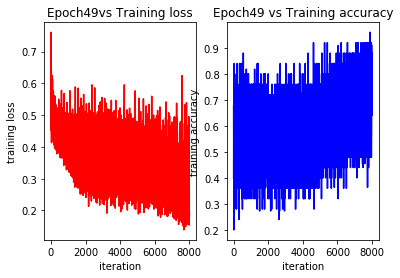

Model saved in ./project1.ckpt
-----  Sample model  -----
input layer: (?, 41, 35, 32, 7)
(?, 41, 35, 32, 7)
conv1 layer : (?, 21, 18, 16, 32)
(?, 21, 18, 16, 32)
conv2 layer : (?, 11, 9, 8, 64)
(?, 11, 9, 8, 64)
conv3 layer : (?, 6, 5, 4, 64)
flatten layer : (?, 7680)
fc4 layer : (?, 1024)
fc5 layer : (?, 384)
fc6 layer : (?, 14)
concatenated tensors: (?, 28)
concat fc-fc layer : (?, 28)
fc final layer : (?, 2)
-----  Start training  -----
training for epoch 0
-  epoch 0: training f1 = 0.554 || training accuracy = 0.529
validation for epoch 0
-  epoch 0: validation f1 = 0.615 || validation accuracy = 0.592
training for epoch 1
-  epoch 1: training f1 = 0.577 || training accuracy = 0.557
validation for epoch 1
-  epoch 1: validation f1 = 0.658 || validation accuracy = 0.656
training for epoch 2
-  epoch 2: training f1 = 0.607 || training accuracy = 0.593
validation for epoch 2
-  epoch 2: validation f1 = 0.642 || validation accuracy = 0.641
training for epoch 3
-  epoch 3: training f1 

training for epoch 45
-  epoch 45: training f1 = 0.639 || training accuracy = 0.621
validation for epoch 45
-  epoch 45: validation f1 = 0.645 || validation accuracy = 0.627
training for epoch 46
-  epoch 46: training f1 = 0.651 || training accuracy = 0.633
validation for epoch 46
-  epoch 46: validation f1 = 0.668 || validation accuracy = 0.651
training for epoch 47
-  epoch 47: training f1 = 0.658 || training accuracy = 0.640
validation for epoch 47
-  epoch 47: validation f1 = 0.636 || validation accuracy = 0.619
training for epoch 48
-  epoch 48: training f1 = 0.665 || training accuracy = 0.647
validation for epoch 48
-  epoch 48: validation f1 = 0.666 || validation accuracy = 0.649
training for epoch 49
-  epoch 49: training f1 = 0.672 || training accuracy = 0.654
validation for epoch 49
-  epoch 49: validation f1 = 0.677 || validation accuracy = 0.660


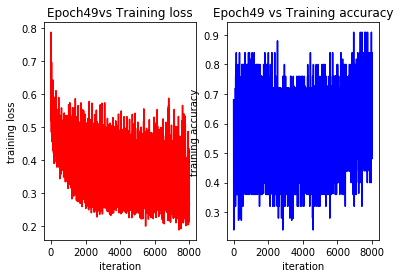

Model saved in ./project2.ckpt
-----  Sample model  -----
input layer: (?, 41, 35, 32, 7)
(?, 41, 35, 32, 7)
conv1 layer : (?, 21, 18, 16, 32)
(?, 21, 18, 16, 32)
conv2 layer : (?, 11, 9, 8, 64)
(?, 11, 9, 8, 64)
conv3 layer : (?, 6, 5, 4, 64)
flatten layer : (?, 7680)
fc4 layer : (?, 1024)
fc5 layer : (?, 384)
fc6 layer : (?, 14)
concatenated tensors: (?, 28)
concat fc-fc layer : (?, 28)
fc final layer : (?, 2)
-----  Start training  -----
training for epoch 0
-  epoch 0: training f1 = 0.574 || training accuracy = 0.552
validation for epoch 0
-  epoch 0: validation f1 = 0.595 || validation accuracy = 0.594
training for epoch 1
-  epoch 1: training f1 = 0.614 || training accuracy = 0.603
validation for epoch 1
-  epoch 1: validation f1 = 0.623 || validation accuracy = 0.649
training for epoch 2
-  epoch 2: training f1 = 0.627 || training accuracy = 0.624
validation for epoch 2
-  epoch 2: validation f1 = 0.623 || validation accuracy = 0.648
training for epoch 3
-  epoch 3: training f1 

training for epoch 45
-  epoch 45: training f1 = 0.656 || training accuracy = 0.637
validation for epoch 45
-  epoch 45: validation f1 = 0.681 || validation accuracy = 0.664
training for epoch 46
-  epoch 46: training f1 = 0.658 || training accuracy = 0.639
validation for epoch 46
-  epoch 46: validation f1 = 0.684 || validation accuracy = 0.666
training for epoch 47
-  epoch 47: training f1 = 0.657 || training accuracy = 0.638
validation for epoch 47
-  epoch 47: validation f1 = 0.697 || validation accuracy = 0.681
training for epoch 48
-  epoch 48: training f1 = 0.666 || training accuracy = 0.647
validation for epoch 48
-  epoch 48: validation f1 = 0.699 || validation accuracy = 0.683
training for epoch 49
-  epoch 49: training f1 = 0.673 || training accuracy = 0.654
validation for epoch 49
-  epoch 49: validation f1 = 0.702 || validation accuracy = 0.686


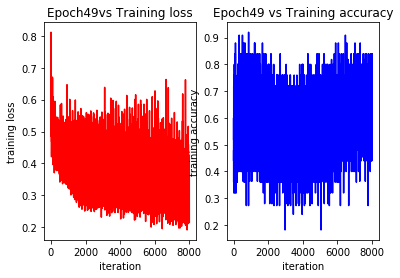

Model saved in ./project3.ckpt
-----  Sample model  -----
input layer: (?, 41, 35, 32, 7)
(?, 41, 35, 32, 7)
conv1 layer : (?, 21, 18, 16, 32)
(?, 21, 18, 16, 32)
conv2 layer : (?, 11, 9, 8, 64)
(?, 11, 9, 8, 64)
conv3 layer : (?, 6, 5, 4, 64)
flatten layer : (?, 7680)
fc4 layer : (?, 1024)
fc5 layer : (?, 384)
fc6 layer : (?, 14)
concatenated tensors: (?, 28)
concat fc-fc layer : (?, 28)
fc final layer : (?, 2)
-----  Start training  -----
training for epoch 0
-  epoch 0: training f1 = 0.547 || training accuracy = 0.521
validation for epoch 0
-  epoch 0: validation f1 = 0.605 || validation accuracy = 0.595
training for epoch 1
-  epoch 1: training f1 = 0.589 || training accuracy = 0.572
validation for epoch 1
-  epoch 1: validation f1 = 0.631 || validation accuracy = 0.629
training for epoch 2
-  epoch 2: training f1 = 0.617 || training accuracy = 0.605
validation for epoch 2
-  epoch 2: validation f1 = 0.648 || validation accuracy = 0.656
training for epoch 3
-  epoch 3: training f1 

training for epoch 45
-  epoch 45: training f1 = 0.697 || training accuracy = 0.680
validation for epoch 45
-  epoch 45: validation f1 = 0.694 || validation accuracy = 0.682
training for epoch 46
-  epoch 46: training f1 = 0.716 || training accuracy = 0.700
validation for epoch 46
-  epoch 46: validation f1 = 0.715 || validation accuracy = 0.705
training for epoch 47
-  epoch 47: training f1 = 0.714 || training accuracy = 0.698
validation for epoch 47
-  epoch 47: validation f1 = 0.730 || validation accuracy = 0.720
training for epoch 48
-  epoch 48: training f1 = 0.729 || training accuracy = 0.713
validation for epoch 48
-  epoch 48: validation f1 = 0.724 || validation accuracy = 0.714
training for epoch 49
-  epoch 49: training f1 = 0.738 || training accuracy = 0.723
validation for epoch 49
-  epoch 49: validation f1 = 0.739 || validation accuracy = 0.729


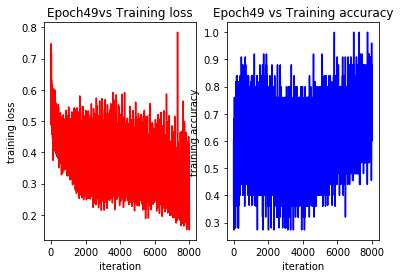

Model saved in ./project4.ckpt
-----  Sample model  -----
input layer: (?, 41, 35, 32, 7)
(?, 41, 35, 32, 7)
conv1 layer : (?, 21, 18, 16, 32)
(?, 21, 18, 16, 32)
conv2 layer : (?, 11, 9, 8, 64)
(?, 11, 9, 8, 64)
conv3 layer : (?, 6, 5, 4, 64)
flatten layer : (?, 7680)
fc4 layer : (?, 1024)
fc5 layer : (?, 384)
fc6 layer : (?, 14)
concatenated tensors: (?, 28)
concat fc-fc layer : (?, 28)
fc final layer : (?, 2)
-----  Start training  -----
training for epoch 0
-  epoch 0: training f1 = 0.550 || training accuracy = 0.524
validation for epoch 0
-  epoch 0: validation f1 = 0.603 || validation accuracy = 0.582
training for epoch 1
-  epoch 1: training f1 = 0.568 || training accuracy = 0.544
validation for epoch 1
-  epoch 1: validation f1 = 0.624 || validation accuracy = 0.608
training for epoch 2
-  epoch 2: training f1 = 0.590 || training accuracy = 0.568
validation for epoch 2
-  epoch 2: validation f1 = 0.622 || validation accuracy = 0.603
training for epoch 3
-  epoch 3: training f1 

training for epoch 45
-  epoch 45: training f1 = 0.703 || training accuracy = 0.686
validation for epoch 45
-  epoch 45: validation f1 = 0.732 || validation accuracy = 0.718
training for epoch 46
-  epoch 46: training f1 = 0.714 || training accuracy = 0.697
validation for epoch 46
-  epoch 46: validation f1 = 0.743 || validation accuracy = 0.729
training for epoch 47
-  epoch 47: training f1 = 0.721 || training accuracy = 0.705
validation for epoch 47
-  epoch 47: validation f1 = 0.733 || validation accuracy = 0.721
training for epoch 48
-  epoch 48: training f1 = 0.733 || training accuracy = 0.717
validation for epoch 48
-  epoch 48: validation f1 = 0.737 || validation accuracy = 0.724
training for epoch 49
-  epoch 49: training f1 = 0.741 || training accuracy = 0.726
validation for epoch 49
-  epoch 49: validation f1 = 0.744 || validation accuracy = 0.733


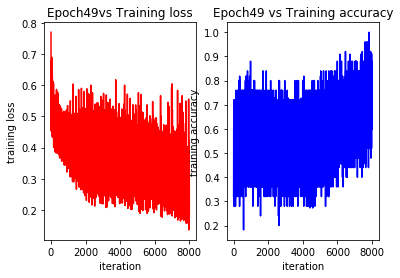

Model saved in ./project5.ckpt


In [35]:
# Clear old computation graphs
#tf.reset_default_graph()

# Train our sample model
#with tf.Session() as sess:
#    with tf.device('/cpu:0'):
#print(X_train.shape)
#trans_test = np.reshape(trans_test, (786,14))

#X_train_random = np.random.randn(*X_train.shape)
#Y_train_random = np.random.randn(*Y_train.shape)

#Y_val_random = np.random.randn(*Y_val.shape)
#Y_val_random = np.zeros(*Y_val.shape)

#with tf.Session() as sess:
#    with tf.device('/device:GPU:0'):
for i in range(0,6):
    tf.reset_default_graph() 
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:               
            model = BaseModel4()
            model.train(sess,i)        

            saver = tf.train.Saver()            
            model_path = saver.save(sess, './project' + str(i) + '.ckpt')
            print("Model saved in %s" % model_path)
            sess.close()


In [ ]:
# Clear old computation graphs
tf.reset_default_graph()


with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:   
        model = BaseModel4()
        saver = tf.train.Saver()
        saver.restore(sess, "./project.ckpt")

        f1 , accuracy = model.evaluate(sess)
        print('***** test accuracy: %.3f  ||  f1_score: %.3f' % (accuracy, f1))
        #saver = tf.train.Saver()
        #model_path = saver.save(sess, "./project.ckpt")
        #print("Model saved in %s" % model_path)
        sess.close()
        

In [6]:
@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

In [16]:
#print(Y_val)  #0, 2, 11

num_classes = 3
minibatch = X_val[[0 ,2, 11]][:]
one_hot_grads=Y_val[[0 ,2, 11]]

print(one_hot_grads)
#one_hot_grad = np.reshape(one_hot_grad, (len(one_hot_grad), ))


seq_mini = np.load('mut_seq_data.npy')
trans_mini = np.load('trans_elecmap_data.npy')
trans_mini = np.reshape(trans_test, (786,14))

seq_mini = seq_mini[[0,2,11]]
trans_mini = trans_mini[[0,2,11]]


#print(minibatch)

batch_size = 3

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
        testmodel = BaseModel4()
        #saver = tf.train.Saver()
        #saver.restore(sess, "./project.ckpt")
        
        fc6 = testmodel.fc6
        
#        outputs = tf.placeholder(tf.float32, [batch_size, 3])
#        signal = tf.multiply(fc6, tf.cast(testmodel.Y, tf.float32))       
#        loss = tf.divide(tf.reduce_sum(signal, 1), 3)
        


        loss = testmodel._loss(testmodel.Y, fc6)  
        #loss = testmodel.loss_op
        
        pool3 = testmodel.pool3
        pool3_grads = testmodel.pool3grad
        
        inputs = tf.placeholder("float",  [batch_size, 41,35,32,1])
#        gb_grad = tf.gradients(loss, testmodel.Y)
        eps = tf.constant(1e-5)
        
#        pool3_grads_norm = tf.nn.l2_normalize(pool3_grads,dim = 0,epsilon=eps)
        
        softmax = tf.nn.softmax(fc6)
        
        init = tf.global_variables_initializer()
        
with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as sess:   
    saver = tf.train.Saver()
    saver.restore(sess, "./project.ckpt")

    prob = sess.run(softmax,feed_dict={testmodel.X:minibatch,testmodel.Y:one_hot_grads, testmodel.seq : seq_mini,
                    testmodel.trans : trans_mini, testmodel.dropout_train : False })
    #gb_grads = sess.run(gb_grad,feed_dict={testmodel.X:minibatch,testmodel.Y:one_hot_grads, testmodel.seq : seq_mini,
    #                testmodel.trans : trans_mini, testmodel.dropout_train : False  })
    pool3_act = sess.run(pool3,feed_dict={testmodel.X:minibatch,testmodel.Y:one_hot_grads, testmodel.seq : seq_mini,
                    testmodel.trans : trans_mini, testmodel.dropout_train : False })
    #pool3_grad = sess.run(pool3_grads,feed_dict={testmodel.X:minibatch,testmodel.Y:one_hot_grads, testmodel.seq : seq_mini,
    #                testmodel.trans : trans_mini, testmodel.dropout_train : False })



[ 2.  0.  0.]
-----  Sample model  -----
intput layer: (?, 41, 35, 32, 1)
(?, 41, 35, 32, 1)
conv1 layer : (?, 21, 18, 16, 32)
(?, 21, 18, 16, 32)
conv2 layer : (?, 11, 9, 8, 64)
(?, 11, 9, 8, 64)
conv3 layer : (?, 6, 5, 4, 64)
flatten layer : (?, 7680)
fc4 layer : (?, 1024)
fc5 layer : (?, 384)
concatenated tensors: (?, 412)
fc6 layer : (?, 3)
INFO:tensorflow:Restoring parameters from ./project.ckpt


INFO:tensorflow:Restoring parameters from ./project.ckpt


In [19]:
print(pool3_act.shape)

(3, 6, 5, 4, 64)


In [16]:
#print(Y_val)  #0, 2, 11

num_classes = 3
minibatch = X_val[[0 ,2, 11]][:]

seq_mini = np.load('mut_seq_data.npy')
trans_mini = np.load('trans_elecmap_data.npy')
trans_mini = np.reshape(trans_test, (786,14))

seq_mini = seq_mini[[0,2,11]]
trans_mini = trans_mini[[0,2,11]]


#print(minibatch)

zero_grads = np.array([0 for i in range(num_classes)])

class_num1 = 0
class_num2 = 2
class_num3 = 2
one_hot_grad1 = zero_grads.copy()
one_hot_grad2 = zero_grads.copy()
one_hot_grad3 = zero_grads.copy()
one_hot_grad1[class_num1] = 1.0
one_hot_grad2[class_num2] = 1.0
one_hot_grad3[class_num3] = 1.0
#one_hot_grad1 = np.expand_dims(one_hot_grad1, axis=0)
#one_hot_grad2 = np.expand_dims(one_hot_grad2, axis=0)
#one_hot_grad3 = np.expand_dims(one_hot_grad3, axis=0)
one_hot_grads = np.concatenate((one_hot_grad1, one_hot_grad2), axis=0)
one_hot_grads = np.concatenate((one_hot_grads, one_hot_grad3), axis=0)
one_hot_grads = np.reshape(one_hot_grads, (3,3 ))
print(one_hot_grads.shape)


batch_size = 3

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
        testmodel = BaseModel4()
        #saver = tf.train.Saver()
        #saver.restore(sess, "./project.ckpt")
        
        fc6 = testmodel.fc6
        
        outputs = tf.placeholder(tf.float32, [batch_size, 3])
        signal = tf.multiply(fc6, tf.cast(testmodel.Y, tf.float32))       
        loss = tf.divide(tf.reduce_sum(signal, 1), 3)
        
        pool3 = testmodel.pool3
        pool3_grads = tf.gradients(loss, pool3)[0]
        
        inputs = tf.placeholder("float",  [batch_size, 41,35,32,1])
        gb_grad = tf.gradients(loss, testmodel.Y)
        eps = tf.constant(1e-5)
        
        pool3_grads_norm = tf.nn.l2_normalize(pool3_grads,dim = 0,epsilon=eps)
        
        softmax = tf.nn.softmax(fc6)
        
        init = tf.global_variables_initializer()
        
with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as sess:   
    saver = tf.train.Saver()
    saver.restore(sess, "./project.ckpt")
    prob = sess.run(softmax,feed_dict={testmodel.X:minibatch,testmodel.Y:one_hot_grads, testmodel.seq : seq_mini,
                    testmodel.trans : trans_mini, testmodel.dropout_train : False })
    gb_grads = sess.run(gb_grad,feed_dict={testmodel.X:minibatch,testmodel.Y:one_hot_grads, testmodel.seq : seq_mini,
                    testmodel.trans : trans_mini, testmodel.dropout_train : False })
    pool5_act = sess.run(pool3,feed_dict={testmodel.X:minibatch,testmodel.Y:one_hot_grads, testmodel.seq : seq_mini,
                    testmodel.trans : trans_mini, testmodel.dropout_train : False })




(3, 3)
-----  Sample model  -----
intput layer: (?, 41, 35, 32, 1)
(?, 41, 35, 32, 1)
conv1 layer : (?, 21, 18, 16, 32)
(?, 21, 18, 16, 32)
conv2 layer : (?, 11, 9, 8, 64)
(?, 11, 9, 8, 64)
conv3 layer : (?, 6, 5, 4, 64)
flatten layer : (?, 7680)
fc4 layer : (?, 1024)
fc5 layer : (?, 384)
concatenated tensors: (?, 412)
fc6 layer : (?, 3)
INFO:tensorflow:Restoring parameters from ./project.ckpt


INFO:tensorflow:Restoring parameters from ./project.ckpt


ValueError: Cannot feed value of shape (3, 3) for Tensor 'Placeholder_1:0', which has shape '(?,)'